# SIMBA: Inference Notebook

This notebook demonstrates how to run inference using **SIMBA** (Spectral Identification of Molecule Bio-Analogues), a deep learning model designed to predict structural similarity between pairs of MS/MS spectra.


### What this notebook covers:
- **Loading the trained SIMBA model** and required libraries
- **Preprocessing MS/MS spectra**: normalizing, cleaning, and formatting inputs
- **Running the model** to obtain similarity predictions between spectral pairs
- **Visualizing results**, including substructure edit distance and MCES predictions

### Requirements:
- Trained SIMBA model checkpoint
- Mass spectrometry input data (e.g., as .mgf or .mzML files, or as processed arrays)
- Dependencies listed in the project repository

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import spectrum_utils.plot as sup
from rdkit import Chem
from hydra import compose, initialize_config_dir

from simba.analog_discovery.simba_analog_discovery import AnalogDiscovery
from simba.utils.plotting_mces import Plotting
from simba.core.data.preprocessing_simba import PreprocessingSimba
from simba.core.models.simba_model import Simba
from simba.utils.config_utils import get_config_path

/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* In this notebook, we load spectra from a mgf file and this is run on SIMBA to produce the corresponding edit distance and mces distances

In [3]:
# Initialize Hydra config
config_path = get_config_path()
with initialize_config_dir(config_dir=str(config_path), version_base=None):
    cfg = compose(config_name="config")

In [ ]:
model_location = (
    "/Users/sebas/projects/data/best_model_20250422_only_massspecgym.ckpt"
)
mgf_file = "/Users/sebas/projects/data/ALL_GNPS_NO_PROPOGATED_wb.mgf"
casmi_file = "/Users/sebas/projects/data/processed_massformer/spec_df.pkl"

## Initialize Simba

In [5]:
simba = Simba(
    model_location, config=cfg, device="cpu", cache_embeddings=True
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of

## load mgf file

In [6]:
all_spectrums = PreprocessingSimba.load_spectra(
    casmi_file, cfg, use_gnps_format=False
)

2026-01-06 11:25:15 - INFO - 158 spectra remaining after filtering.


In [7]:
len(all_spectrums)

158

Let's take 400=20x20 random pairs and calculate the similarities.

In [8]:
np.random.seed(42)
random_indexes_0 = np.random.randint(0, len(all_spectrums), 20)
random_indexes_1 = np.random.randint(0, len(all_spectrums), 20)

In [9]:
## spectrums of the first index
import copy

all_spectrums_0 = copy.deepcopy(
    [all_spectrums[index] for index in random_indexes_0]
)
all_spectrums_1 = copy.deepcopy(
    [all_spectrums[index] for index in random_indexes_1]
)

In [10]:
len(all_spectrums_0)

20

## Predictions

In [11]:
sim_ed, sim_mces = simba.predict(all_spectrums_0, all_spectrums_1)

20it [00:00, 11104.86it/s]
20it [00:00, 41589.53it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


running
Processing embeddings ...
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores



running
Processing embeddings ...
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


/Users/nikitakubrakov/bittremieuxlab/simba/.venv/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['log_sigma1', 'log_sigma2']
20it [00:00, 3973.76it/s]

Elapsed time: 0.06 seconds


## Ground truth

In [12]:
from simba.core.data.ground_truth import GroundTruth

In [13]:
ground_truth_ed = GroundTruth.compute_edit_distance(
    all_spectrums_0, all_spectrums_1
)

In [14]:
import myopic_mces

In [15]:
ground_truth_mces = GroundTruth.compute_mces(all_spectrums_0, all_spectrums_1)

(array([  4.,   4.,  33., 184.,  82.,  63.,  17.,   9.,   1.,   3.]),
 array([ 0. ,  5.2, 10.4, 15.6, 20.8, 26. , 31.2, 36.4, 41.6, 46.8, 52. ]),
 <BarContainer object of 10 artists>)

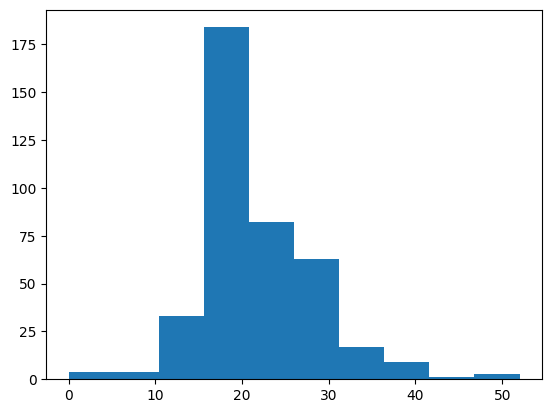

In [16]:
import matplotlib.pyplot as plt

plt.hist(np.reshape(ground_truth_mces, -1))

## Comparison between predictions and ground truth

In [17]:
from scipy.stats import spearmanr

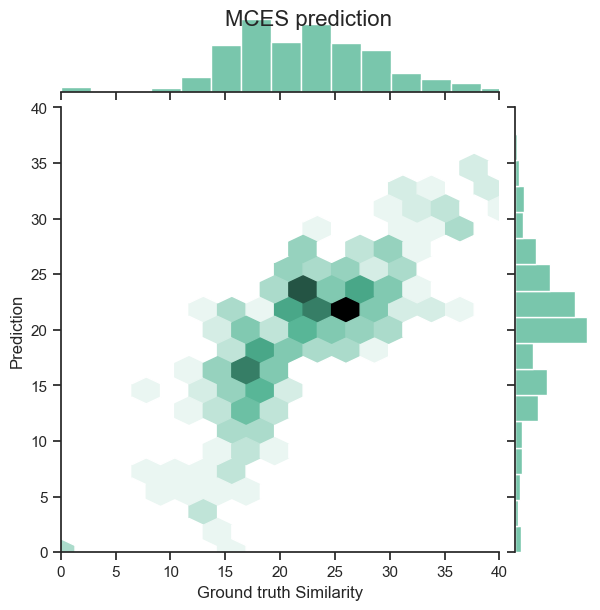

In [18]:
Plotting.plot_mces(np.reshape(ground_truth_mces, -1), np.reshape(sim_mces, -1))

Confusion matrix per sample:
[[266  61  26  17   5   5]
 [  0   2   1   2   1   0]
 [  0   1   4   1   0   0]
 [  0   1   0   3   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   1   0   3]]
Accuracy: 0.695
[[0.7        0.16052632 0.06842105 0.04473684 0.01315789 0.01315789]
 [0.         0.33333333 0.16666667 0.33333333 0.16666667 0.        ]
 [0.         0.16666667 0.66666667 0.16666667 0.         0.        ]
 [0.         0.25       0.         0.75       0.         0.        ]
 [       nan        nan        nan        nan        nan        nan]
 [0.         0.         0.         0.25       0.         0.75      ]]


/Users/nikitakubrakov/bittremieuxlab/simba/simba/utils/plotting_mces.py:66: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


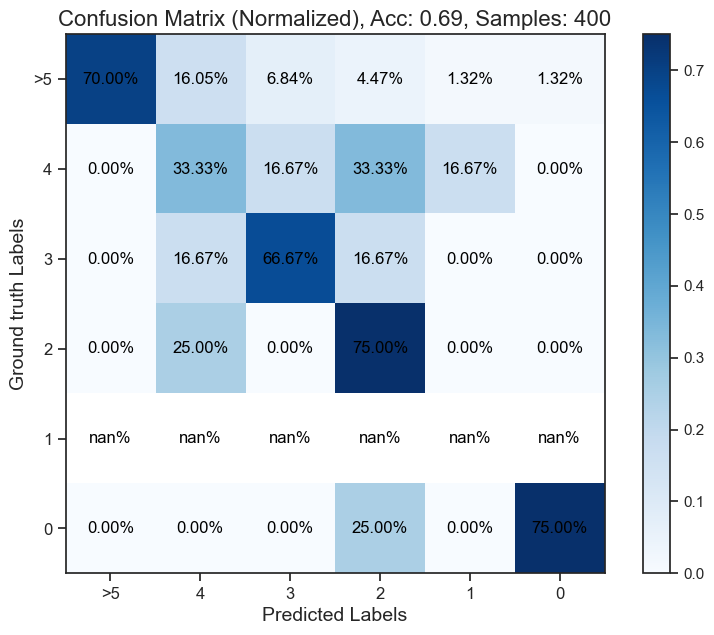

In [19]:
Plotting.plot_cm(true=ground_truth_ed, preds=sim_ed)

## Check the closest spectra

* It returns a ranking matrix where if the score is higher, the similarity is higher based on reranking of MCES and Edit distance 

In [20]:
ranking = AnalogDiscovery.compute_ranking(sim_mces, sim_ed)

## Plot the closest spectra

In [21]:
target_index = 9

In [22]:
best_match_index = np.argmax(ranking[target_index])

* Ground truth

In [23]:
print(
    f"Edit distance {ground_truth_ed[target_index, best_match_index]}, MCES distance {ground_truth_mces[target_index, best_match_index]}"
)

Edit distance 5.0, MCES distance 16.0


* Prediction

In [24]:
print(
    f"Edit distance {sim_ed[target_index, best_match_index]}, MCES distance {sim_mces[target_index, best_match_index]}"
)

Edit distance 4, MCES distance 13.3394193649292


In [25]:
spectra_0 = all_spectrums_0[target_index]

In [26]:
spectra_1 = all_spectrums_1[best_match_index]

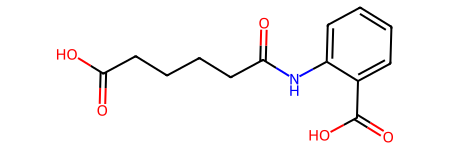

In [27]:
Chem.MolFromSmiles(spectra_0.params["smiles"])

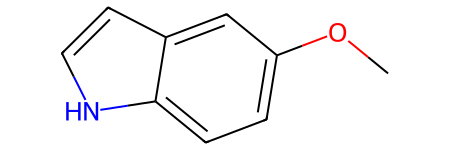

In [28]:
Chem.MolFromSmiles(spectra_1.params["smiles"])

In [29]:
spectra_0.params

{'spectrumid': '307 M+H',
 'name': '307 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 307,
 'smiles': 'O=C(O)CCCCC(=O)Nc1ccccc1C(=O)O',
 'ionmode': 'Positive',
 'pepmass': [266.102037994695],
 'charge': [1],
 'libraryquality': 1}

In [30]:
spectra_1.params

{'spectrumid': '226 M+H',
 'name': '226 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 226,
 'smiles': 'COc1ccc2[nH]ccc2c1',
 'ionmode': 'Positive',
 'pepmass': [148.075452106098],
 'charge': [1],
 'libraryquality': 1}

<Axes: xlabel='m/z', ylabel='Intensity'>

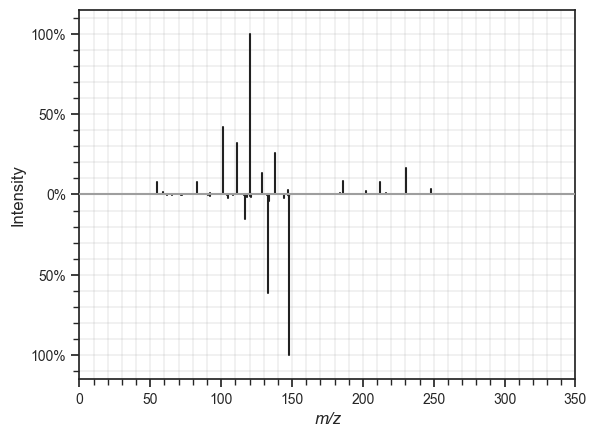

In [31]:
sup.mirror(spectra_0, spectra_1)